<a href="https://colab.research.google.com/github/EquinoxJF/StackedRegression/blob/main/MVP_Stacking_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Previsor de Preços de Imóveis - Análise Avançada de Residências em Ames, Iowa**

**Contexto:**

Ao desafiar os participantes a prever o preço final de residências em Ames, Iowa, esta competição no Kaggle se destaca por sua complexidade e detalhamento. Utilizando um conjunto de dados composto por 79 variáveis explicativas, os competidores têm a oportunidade de explorar quase todos os aspectos de uma casa residencial. Contrariamente à crença comum de que apenas o número de quartos ou tamanho do terreno influenciam as negociações de preço, este conjunto de dados revela que fatores menos óbvios, como a altura do teto do porão ou a proximidade de uma ferrovia leste-oeste, também têm impacto significativo. A competição não apenas desafia os participantes a mergulhar profundamente nas nuances do mercado imobiliário, mas também a aplicar suas habilidades analíticas para extrair insights valiosos que possam prever com precisão o valor de uma propriedade.

**Estrutura:**

1. **Importação das bibliotecas necessárias:** Inclui as bibliotecas de análise de dados, processamento e os machine learning.
2. **Acesso aos dados e análise exploratória inicial:** Carrega o conjunto de dados fornecido e executa-se uma análise exploratória para compreender as características dos dados e sua influência na variável de interesse.
3. **Pré-processamento e limpeza dos dados:** Trata-se os valores ausentes, transformando variáveis desnecessárias, e realiza a codificação de variáveis categóricas, normalização ou padronização de variáveis numéricas, conforme necessário.
4. **Criação e valiação dos modelos base:** Diversos modelos base são treinados, e suas métricas são analisadas para selecionar os melhores.
5. **Criação e avaliação dos modelos de stacking e ensemble:** Os melhores modelos são utilizados em métodos de stacking e ensemble, tendo por fim suas métricas avaliadas e a submissão da competição efetivada.

Essa estrutura detalhada oferece uma base sólida para abordar o desafio complexo de prever preços de imóveis, enfatizando a importância da análise detalhada dos dados, seleção cuidadosa de variáveis e a aplicação criteriosa de técnicas de modelagem preditiva.

**Créditos:**

O notebook foi desenvolvido e documentado pelo aluno: Bruno Machado Ferreira

**Linkedin:**

www.linkedin.com/in/bruno-machado-ferreira-67888019a


**Dataset:**

Este conjunto de dados foi adquirido através do Kaggle, um renomado portal online que serve como um campo de atuação para cientistas de dados, aficionados por aprendizado de máquina e profissionais da área. Ele é utilizado exclusivamente para fins educativos dentro do escopo desta competição, visando desafiar os participantes a prever o preço final de imóveis residenciais em Ames, Iowa, com base em uma abrangente gama de variáveis explicativas. Este dataset apresenta uma rica oportunidade para aplicar e aprimorar técnicas de machine learning e análise de dados. Para obter mais detalhes sobre este conjunto de dados, consulte o seguintes links:

https://jse.amstat.org/v19n3/decock.pdf - Link com o projeto do autor do dataset

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques - Link da competição

**Consultas:**

Para realização deste projeto foram utilizadas técnicas disponíveis em alguns notebooks do Kaggle que merecem o seu determinado crédito:


https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python - Fornece de forma clara técnicas de análise de dados extremamente úteis para compreender o contexto do problema.


https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard - Fornece os modelos base de regressão e stacking usados para elaborar este modelo


https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset?rvi=1 - Fornece técnicas de preprocessamento de dados úteis para melhorar os resultados dos modelos

# 1. Importação das bibliotecas essenciais para a execução do notebook:

In [ ]:
# Importações para manipulação dos dados
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Limitando decimais para no máximo 3 casas

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid') # Setando o estilo do seaborn

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # Ignora alertas do seaborn e do sklearn

# Importações para pré-processamento e modelagem
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Importações de algoritmos de machine learning
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

# Importações diversas para manipulação de sistema de arquivos, datas e operações matemáticas
import os
from datetime import datetime
import pickle

**Função para Sumarizar Dados**

In [ ]:
def resumo_dataframe(df):
    """
    Gera um resumo abrangente para um DataFrame do pandas.

    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser resumido.

    Retorna:
    pandas.DataFrame: Um DataFrame contendo o resumo das informações.
    """
    print(f"Resumo do DataFrame:\nNúmero de colunas: {df.shape[1]}\nNúmero de entradas: {df.shape[0]}")
    print("-" * 40)
    resumo = pd.DataFrame()
    resumo['Tipo'] = df.dtypes
    resumo['Contagem'] = df.count()
    resumo['Contagem de Nulos'] = df.isnull().sum()
    resumo['Percentual de Nulos'] = (df.isnull().sum() / df.shape[0] * 100).round(2)
    resumo['Valores Únicos'] = df.nunique()
    return resumo

# 2. Acesso aos dados e análise exploratória inicial

Os dados são disponibilizados em dois arquivos, um para treinamento e outro para teste. Em seguida, define-se o caminho para esses arquivos e os converte em dataframes.

In [ ]:
# Caminhos atualizados para os arquivos enviados
train_path = 'https://raw.githubusercontent.com/EquinoxJF/StackedRegression/main/train.csv'
test_path = 'https://raw.githubusercontent.com/EquinoxJF/StackedRegression/main/test.csv'

# Transformando os arquivos CSV em DataFrames
try:
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
except FileNotFoundError as e:
    print(f"Erro ao carregar o arquivo: {e}")
except pd.errors.EmptyDataError as e:
    print(f"Arquivo vazio: {e}")
except Exception as e:
    print(f"Erro desconhecido: {e}")

**Análise Inicial**

Utiliza-se a função de resumo para obter informações sobre o dataframe de treino

In [ ]:
# Resmuo do dataset de treino
resumo_dataframe(df_train)

Resumo do DataFrame:
Número de colunas: 81
Número de entradas: 1460
----------------------------------------


,Tipo,Contagem,Contagem de Nulos,Percentual de Nulos,Valores Únicos
Id,int64,1460,0,0.000,1460
MSSubClass,int64,1460,0,0.000,15
MSZoning,object,1460,0,0.000,5
LotFrontage,float64,1201,259,17.740,110
LotArea,int64,1460,0,0.000,1073
...,...,...,...,...,...
MoSold,int64,1460,0,0.000,12
YrSold,int64,1460,0,0.000,5
SaleType,object,1460,0,0.000,9
SaleCondition,object,1460,0,0.000,6


Utiliza-se a função de resumo para obter informações sobre o dataframe de teste

In [ ]:
# Resmuo do dataset de teste
resumo_dataframe(df_test)

Resumo do DataFrame:
Número de colunas: 80
Número de entradas: 1459
----------------------------------------


,Tipo,Contagem,Contagem de Nulos,Percentual de Nulos,Valores Únicos
Id,int64,1459,0,0.000,1459
MSSubClass,int64,1459,0,0.000,16
MSZoning,object,1455,4,0.270,5
LotFrontage,float64,1232,227,15.560,115
LotArea,int64,1459,0,0.000,1106
...,...,...,...,...,...
MiscVal,int64,1459,0,0.000,26
MoSold,int64,1459,0,0.000,12
YrSold,int64,1459,0,0.000,5
SaleType,object,1458,1,0.070,9


Verifica-se características estatísticas da variável alvo para melhor entendimento.

In [ ]:
# Estatística descritivas da variável alvo
df_train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

Com base nos resultados obtidos, pode-se afirmar que um valor mínimo diferente de zero sugere a ausência de erros nos dados da variável alvo.

Verifica-se então a distribuição dos dados do alvo.

Assimetria: 1.88
Curtose: 6.54


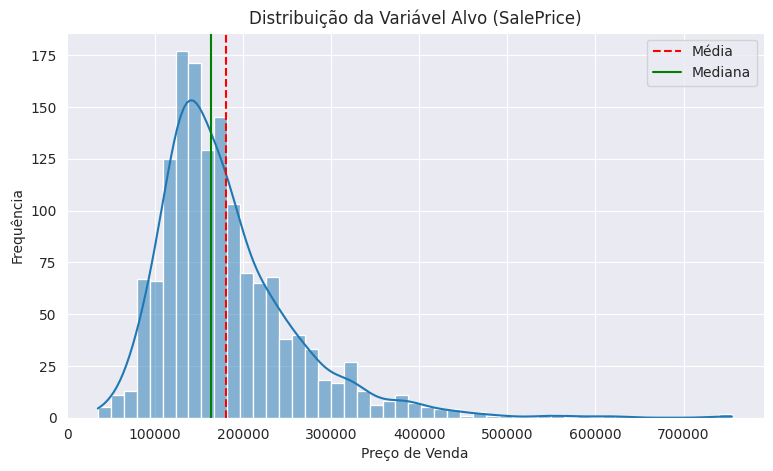

In [ ]:
# Distribuição da Variável Alvo
plt.figure(figsize=(9, 5))
sns.histplot(df_train['SalePrice'], kde=True).set_title("Distribuição da Variável Alvo (SalePrice)")
plt.xlabel("Preço de Venda")
plt.ylabel("Frequência")
plt.axvline(x=df_train['SalePrice'].mean(), color='red', linestyle='--', label='Média')
plt.axvline(x=df_train['SalePrice'].median(), color='green', linestyle='-', label='Mediana')
plt.legend()

# Calcula e imprime a assimetria
assimetria = df_train['SalePrice'].skew().round(2)
curtose = df_train['SalePrice'].kurt().round(2)
print(f"Assimetria: {assimetria}")
print(f"Curtose: {curtose}")

A maioria dos dados está concentrada no lado esquerdo do gráfico, com um pico inicial e depois caindo rapidamente e se estendendo para a direita, indicando uma cauda longa. Isso sugere que há uma assimetria positiva (ou seja, a cauda do gráfico se estende mais para os valores mais altos). A distribuição também mostra o que parece ser uma acentuação, com um pico mais afiado do que se esperaria em uma distribuição normal. O gráfico também inclui uma curva de ajuste normal, que ilustra o desvio da distribuição real da curva normal teórica.

**Relacionamento Variáveis-Alvo**

Inicia-se a análise dos dados com algumas variáveis chaves que podem ter relacionamento direto com 'SalePrice'.

Cria-se um gráfico de disperção de 'GrLivArea', que é a área habitável em metros quadrado no nível do solo, com a variável alvo. Visto que esta é a variável com mais chances de ter um relacionamento positivo com o alvo.

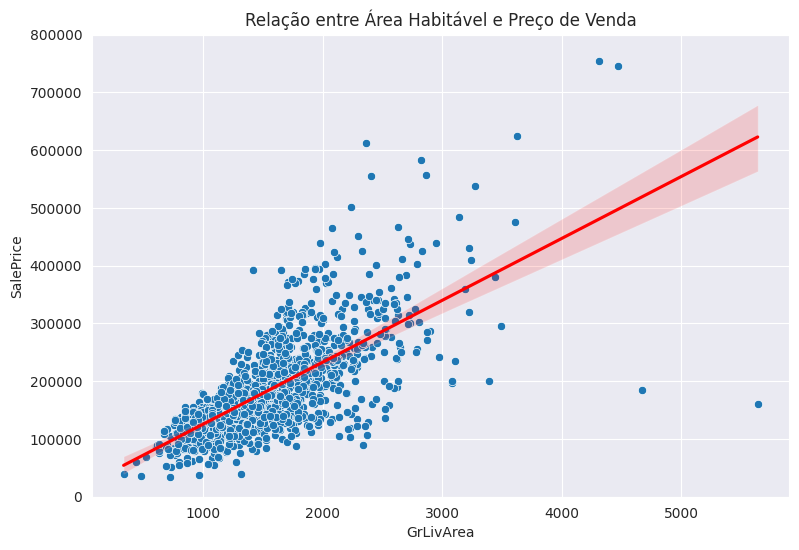

Correlação entre 'GrLivArea' e 'SalePrice': 0.71


In [ ]:
# Gráfico de disperção com as variáveis 'GrLivArea' e 'SalePrice'
plt.figure(figsize=(9, 6))  # Define o tamanho da figura
sns.scatterplot(data=df_train, x='GrLivArea', y='SalePrice')  # Cria o gráfico de dispersão com Seaborn

# Adiciona título e rótulos
plt.title('Relação entre Área Habitável e Preço de Venda')
plt.xlabel('Área Habitável Acima do Solo (GrLivArea)')
plt.ylabel('Preço de Venda (SalePrice)')

# Linha de tendência
sns.regplot(x='GrLivArea', y='SalePrice', data=df_train, scatter=False, color='red')

plt.ylim(0, 800000)  # Define o limite do eixo Y
plt.show()

# Calcula e imprime a correlação
correlacao = df_train['GrLivArea'].corr(df_train['SalePrice']).round(2)
print(f"Correlação entre 'GrLivArea' e 'SalePrice': {correlacao}")

O gráfico de dispersão indica uma correlação positiva entre a área habitável e o preço de venda dos imóveis. Contudo, observa-se que a variação nos preços de venda se amplia com o aumento da área habitável, sugerindo a influência de outros fatores no preço das residências de maior tamanho. A presença de outliers aponta para exceções que podem ser explicadas por características distintas não representadas apenas pela área habitável, especialmente nos dois casos abaixo de 200000 em 'SalePrice' com 'GrLivArea' superior a 4000.

Decide-se então remover os dois registros de imóveis com 'GrLvArea' superior a 4000 e 'SalePrice' excepcionalmente baixo. Embora a remoção de outliers não seja sempre aconselhável, optou-se por excluir esses dois registros específicos devido à sua notável discrepância: áreas habitáveis significativamente grandes com preços inesperadamente reduzidos. Adicionalmente, o criador do conjunto de dados sugere a exclusão de 'qualquer casa com mais de 4000 pés quadrados' da análise.

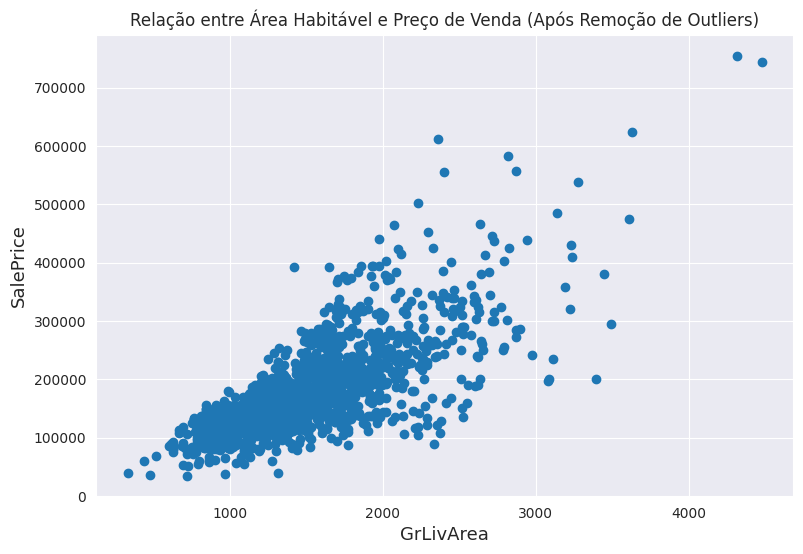

In [ ]:
# Deletando Outliers
train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

# Checando o gráfico novamente com aprimoramentos
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Relação entre Área Habitável e Preço de Venda (Após Remoção de Outliers)')
plt.show()

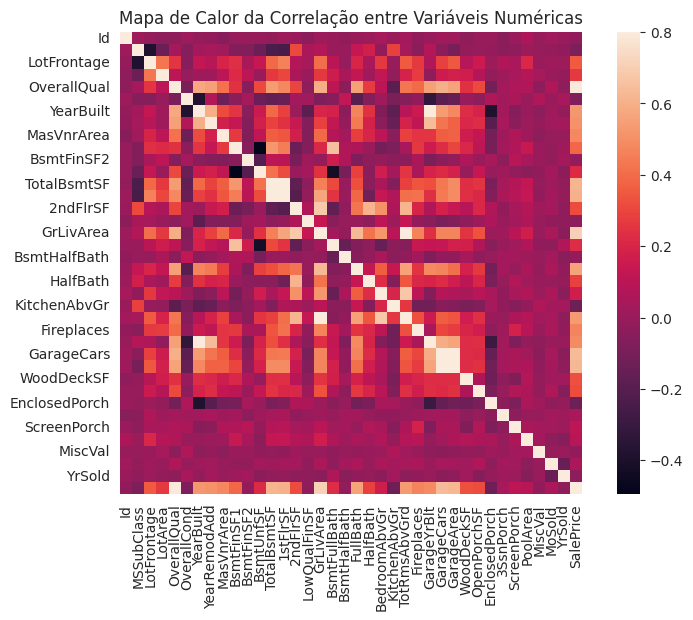

In [ ]:
# Selecionamos as colunas numéricas
numeric_df_train = df_train.select_dtypes(include=[np.number])

# Cálculo da correlação das variáveis numéricas
corrmat = numeric_df_train.corr()

# Cálculo da correlação das váriaveis numéricas
corrmat = numeric_df_train.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, vmax=.8, square=True)

# Título
plt.title('Mapa de Calor da Correlação entre Variáveis Numéricas')
plt.show()

A qualidade geral, tamanho da área habitável e do porão possuem correlações positivas fortes com o preço de venda, sugerindo que são preditores importantes do valor do imóvel. Há também indícios de multicolinearidade entre algumas variáveis, o que requer atenção na modelagem preditiva.

Realiza-se então o mapa de calor com as variáveis mais correlacionadas.

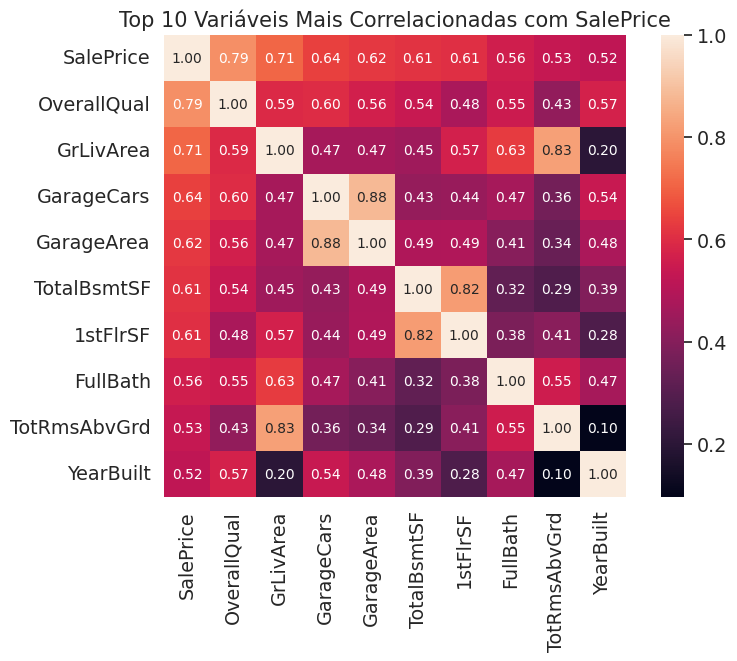

In [ ]:
# Correlação com variáveis mais correlacionadas
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)

# Configurando o tamanho da figura e a escala da fonte
plt.figure(figsize=(9, 6))
sns.set(font_scale=1.25)

# Criando o mapa de calor com as k variáveis mais correlacionadas
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)

# Título
plt.title('Top 10 Variáveis Mais Correlacionadas com SalePrice')

# Mostra o gráfico
plt.show()

Dentre as mais correlacionadas, o mapa de calor confirma com os valores que a qualidade geral 'OverallQual' e a área habitável 'GrLivArea' são as variáveis que mais fortemente influenciam o preço de venda. Existe multicolinearidade entre o tamanho do garagem 'GarageArea' e o número de carros 'GarageCars' que ela comporta, assim como entre o tamanho do porão 'TotalBsmtSF' e a área do primeiro andar '1stFlrSF', o que sugere que essas informações podem ser redundantes. Variáveis como o número de banheiros completos, o número total de cômodos acima do solo e o ano de construção também são moderadamente correlacionadas com o preço de venda, mas menos fortes que a qualidade geral e a área habitável.

In [ ]:
# Deletando variáveis com multicolinearidade
train = df_train.drop(['GarageArea'], axis=1)
train = df_train.drop(['TotalBsmtSF'], axis=1)

Por fim, realiza-se uma análise de pairplot destas variáveis mais correlacioandas.

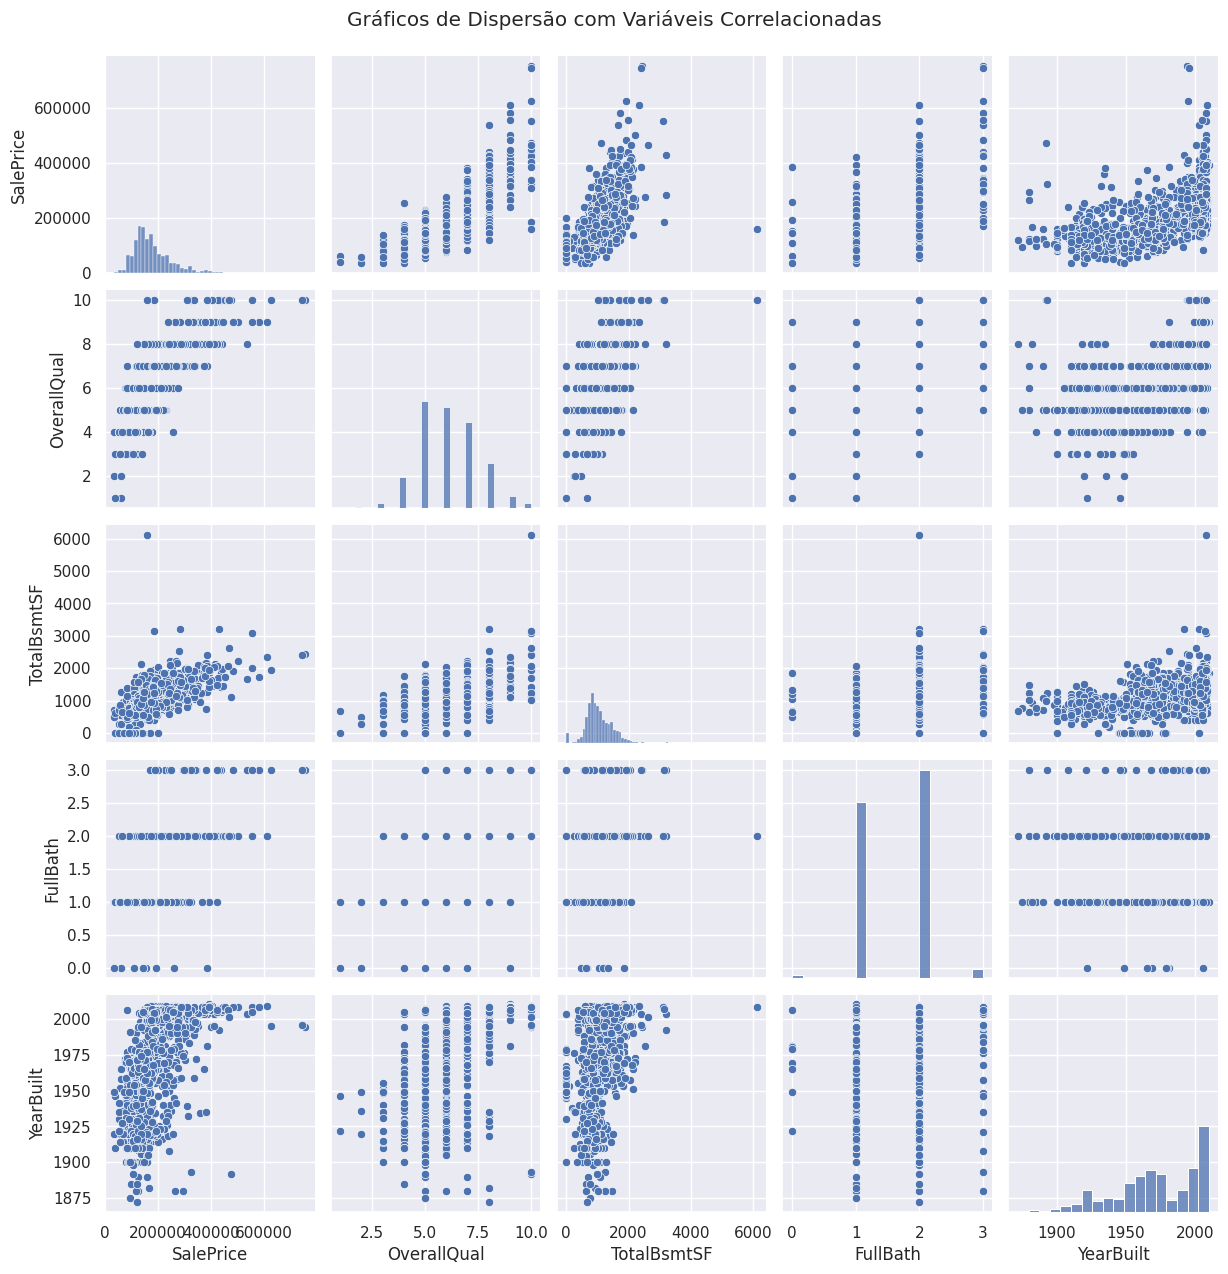

In [ ]:
# Gráficos de Disperção com Váriaveis Correlacionadas
sns.set()
cols = ['SalePrice', 'OverallQual', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)

plt.suptitle('Gráficos de Dispersão com Variáveis Correlacionadas', y=1.02)  # Ajuste para não cortar o título
plt.show()

De acordo com os resultados é possível observar que:

1. **SalePrice e OverallQual**: Existe uma tendência de que quanto maior a qualidade geral ('OverallQual'), maior é o preço de venda ('SalePrice'). A correlação parece ser forte e positiva.

2. **SalePrice e TotalBsmtSF**: A área do porão total ('TotalBsmtSF') também mostra uma correlação positiva com o preço de venda, onde casas com porões maiores tendem a ter preços mais altos.

3. **SalePrice e FullBath**: O número de banheiros completos ('FullBath') parece ter uma relação moderada com o preço de venda, mas não tão forte quanto 'OverallQual' ou 'GarageCars'.

4. **SalePrice e YearBuilt**: Há uma tendência de preços de venda mais altos para casas mais novas, indicando uma correlação positiva entre o ano de construção ('YearBuilt') e o preço de venda.


# 3. Pré-processamento e limpeza dos dados

**Normalização da Variável Alvo**

Realiza-se então o processo de normalização (ou padronização) que ajuda a garantir que as variáveis estejam em escalas semelhantes, o que pode acelerar a convergência do algoritmo de otimização usado para encontrar os coeficientes da regressão linear.


 mu = 180921.20 and sigma = 79415.29



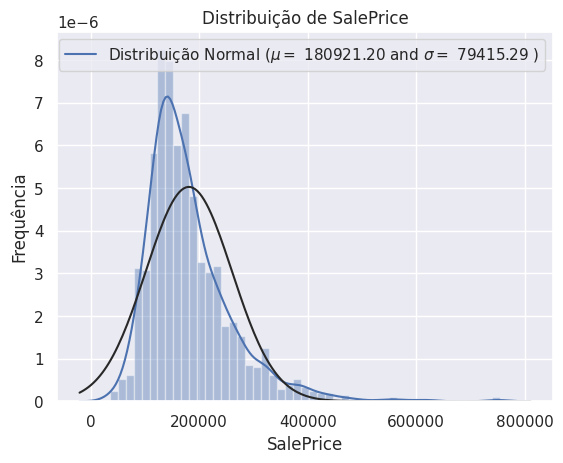

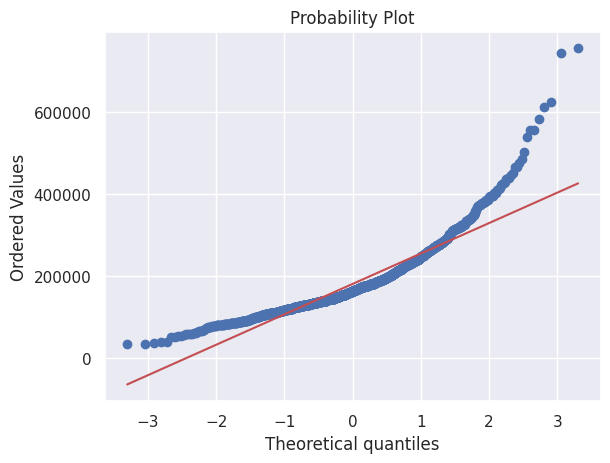

In [ ]:
# Plotando a distribuição de SalePrice e ajustando uma distribuição normal
sns.distplot(df_train['SalePrice'] , fit=norm);

# Obtém os parâmetros ajustados usados pela função
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Agora plota a distribuição
plt.legend(['Distribuição Normal ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequência')
plt.title('Distribuição de SalePrice')

# Obtém também o gráfico QQ
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

Em resumo:

1. Histograma com Distribuição Normal Sobreposta:
   - A média dos dados é de cerca de 180,942.14 e o desvio padrão é aproximadamente 79,494.28.
   - A distribuição tem um pico mais alto e estreito e uma assimetria à direita, não se ajustando perfeitamente à curva normal teórica.
   - A escala logarítmica no eixo das frequências indica uma grande variação na frequência dos dados.

2. Plot de Probabilidade (Q-Q Plot):
   - Os dados não seguem perfeitamente uma distribuição normal.
   - Existe uma variação maior nos extremos, indicando caudas mais pesadas que a normal e potencial presença de outliers.
   - A tendência central e a variância da variável são comparáveis às de uma distribuição normal em grande parte dos dados, mas há desvios significativos.


Ambos os gráficos sugerem que, enquanto os dados têm algumas características de uma distribuição normal, eles apresentam assimetria e kurtose que afastam-se da normalidade, o que pode exigir transformações nos dados ou métodos estatísticos não paramétricos para análises posteriores.

**Transformação Logarítma da Variável Alvo**


 mu = 12.02 and sigma = 0.40



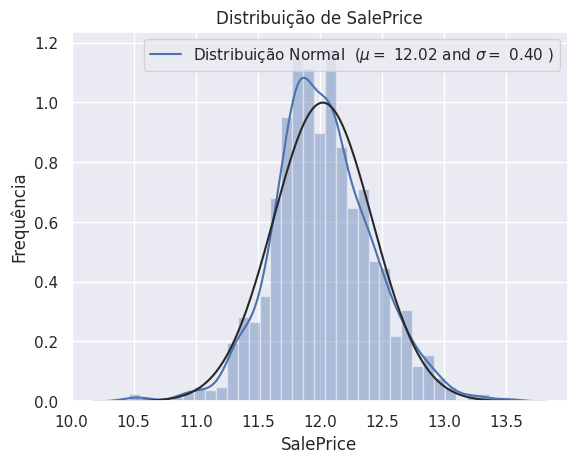

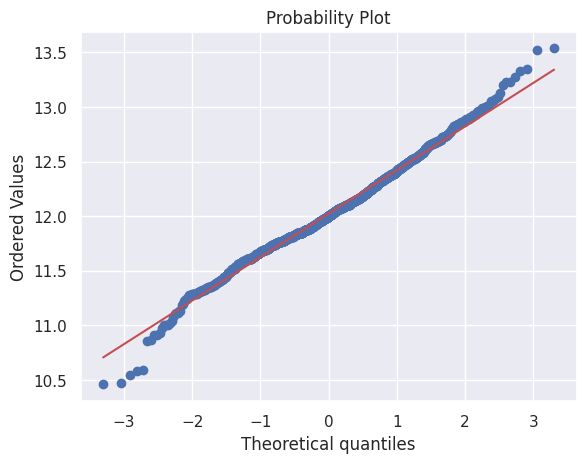

In [ ]:
# Usando a função log1p do numpy que aplica log(1+x) a todos os elementos da coluna
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

# Verificar a nova distribuição
sns.distplot(df_train['SalePrice'] , fit=norm);

# Obter os parâmetros ajustados usados pela função
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plotando a distribuiçãon
plt.legend(['Distribuição Normal  ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequência')
plt.title('Distribuição de SalePrice')

# Plotando gráfico Q-Q
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

Os gráficos mostram que a aplicação da transformação logarítmica `log(1+x)` aos dados SalePrice melhorou a aderência da distribuição ao modelo normal. No histograma, a distribuição dos dados transformados segue de perto a curva normal teórica, com uma média (µ) de aproximadamente 12.02 e um desvio padrão (σ) de cerca de 0.40. O gráfico Q-Q confirma essa melhoria, com os pontos alinhados mais de perto à linha teórica, exceto por pequenos desvios nos extremos. Ambos os gráficos indicam que a transformação foi eficaz em tornar a distribuição mais próxima de uma normal, o que é desejável para muitas técnicas estatísticas.

In [ ]:
#Salvamos as colunas 'Id'
train_ID = df_train['Id']
test_ID = df_test['Id']

# Agora retiramos a coluna 'Id' que não contribui para predição dos valores
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

# Checagem para verificar se as colunas foram retiradas
print("\nO tamanho dos dados de treino após retirarmos a coluna Id é: {} ".format(df_train.shape))
print("\nO tamanho dos dados de teste após retirarmos a coluna Id é: {} ".format(df_test.shape))


O tamanho dos dados de treino após retirarmos a coluna Id é: (1460, 80) 

O tamanho dos dados de teste após retirarmos a coluna Id é: (1459, 79) 


**Tratamento de Valores Ausentes**

Como foram detectados valores ausentes tanto nos dados de treino como nos de teste cria-se um dataset com todos os dados para facilitar as transformações dos dados

In [ ]:
# Juntaremos agora os dados de treino e teste
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("O tamanho de todos os dados são: {}".format(all_data.shape))

O tamanho de todos os dados são: (2919, 79)


A seguir é verificado a porcentagem de valores ausentes

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Porcentagem de Ausentes:' :all_data_na})
missing_data.head(20)

,Porcentagem de Ausentes:
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
MasVnrType,60.500
FireplaceQu,48.647
LotFrontage,16.650
GarageFinish,5.447
GarageQual,5.447
GarageCond,5.447


Text(0.5, 1.0, 'Porcentagem de dados ausentes por variável')

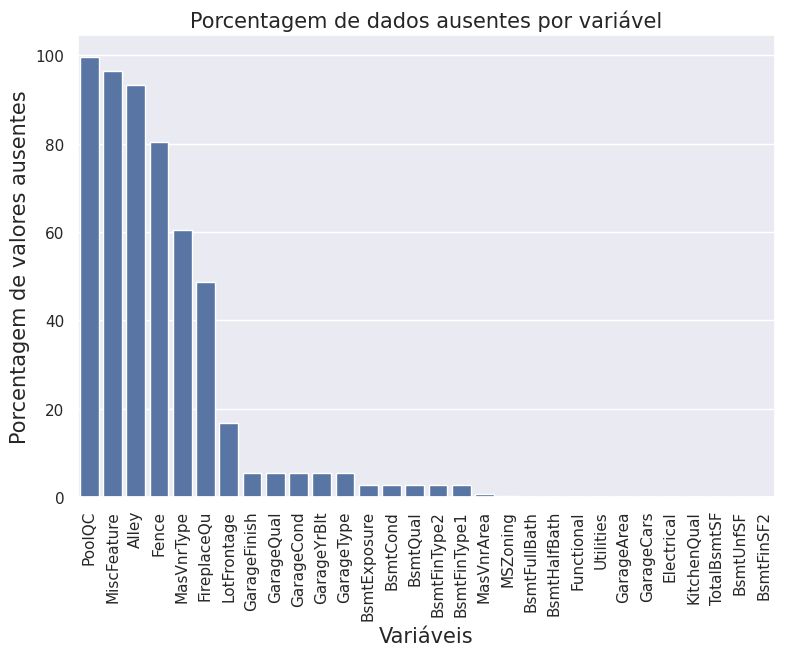

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Variáveis', fontsize=15)
plt.ylabel('Porcentagem de valores ausentes', fontsize=15)
plt.title('Porcentagem de dados ausentes por variável', fontsize=15)

In [ ]:
# PoolQC: a descrição dos dados indica que NA significa "Sem Piscina".
# Isso faz sentido, considerando a grande proporção de valores ausentes (+99%) e o fato de que a maioria das casas,
# de modo geral, não possui piscina.
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

# MiscFeature: a descrição dos dados indica que NA significa "sem características diversas".
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

# Alley: a descrição dos dados indica que NA significa "sem acesso por beco".
all_data["Alley"] = all_data["Alley"].fillna("None")

# Fence: a descrição dos dados indica que NA significa "sem cerca".
all_data["Fence"] = all_data["Fence"].fillna("None")

# FireplaceQu: a descrição dos dados indica que NA significa "sem lareira".
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

# LotFrontage: Considerando que a área de cada rua conectada à propriedade da casa provavelmente
# tem uma área semelhante às outras casas em seu bairro, podemos preencher os valores ausentes pela mediana da LotFrontage do bairro.
# Agrupamos por bairro e preenche o valores ausentes com mediana da LotFrontage do bairro de referência.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# GarageType, GarageFinish, GarageQual e GarageCond: Substituindo dados ausentes por None.
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

# GarageYrBlt, GarageArea e GarageCars: Substituindo dados ausentes por 0 (Já que Sem garagem = sem carros nessa garagem).
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath e BsmtHalfBath: os valores ausentes provavelmente são zero por não terem porão.
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 e BsmtFinType2: Para todas essas características categóricas relacionadas ao porão,
# NaN significa que não existe porão.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

# MasVnrArea e MasVnrType: NA provavelmente significa que essas casas não possuem revestimento de alvenaria.
# Podemos preencher com 0 para a área e None para o tipo.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# MSZoning (A classificação geral de zoneamento): 'RL' é de longe o valor mais comum. Portanto, podemos preencher os valores ausentes com 'RL'.
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# Utilities: Para essa característica categórica, todos os registros são "AllPub", exceto por um "NoSeWa" e 2 NA.
# Como a casa com 'NoSeWa' está no conjunto de treinamento, essa característica não ajudará na modelagem preditiva.
# Podemos, então, removê-la com segurança.
all_data = all_data.drop(['Utilities'], axis=1)

# Functional: a descrição dos dados indica que NA significa típico.
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# Electrical: Tem um valor NA. Como essa característica tem predominantemente 'SBrkr', podemos definir isso para o valor ausente.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# KitchenQual: Apenas um valor NA, e assim como em Electrical, definimos 'TA' (que é o mais frequente) para o valor ausente em KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# Exterior1st e Exterior2nd: Novamente, tanto Exterior 1 quanto Exterior 2 têm apenas um valor ausente. Substituiremos pelo texto mais comum.
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

# SaleType: Preencher novamente com o mais frequente, que é "WD".
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# MSSubClass: Na provavelmente significa Sem classe de construção. Podemos substituir os valores ausentes por None.
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [ ]:
# Checamos novamente para verificar se temos valores ausentes
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Porcentagem de Ausentes' :all_data_na})
missing_data.head()

,Porcentagem de Ausentes


**Feature Engineering**

Com os valores ausentes tratados procedemos para mais algumas feature engineering trasnformando algumas variáveis numéricas que podem ser interpretadas como categóricas

In [ ]:
# Transformação de variáveis numéricas em categóricas
all_data = all_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45",
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75",
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120",
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)

In [ ]:
# Codifica-se as variávels que possuem ordem
all_data.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                  "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                  "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                  "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                  "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                  "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                  "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                  "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                  "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                  "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
                  "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                  "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                  "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                  "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                  "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                  "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                  "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                  "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                  "Street" : {"Grvl" : 1, "Pave" : 2},
                  }, inplace=True)

In [ ]:
# Define colunas que serão processadas
cols = ('CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

# Processo de Label Encoding para as colunas restantes
for c in cols:
    lbl = LabelEncoder()
    # Aplicando LabelEncoder apenas se a coluna ainda existir no DataFrame
    if c in all_data.columns:
        all_data[c] = lbl.fit_transform(all_data[c].values)

# Formato dos dados
print('Formato de todos os dados: {}'.format(all_data.shape))

Formato de todos os dados: (2919, 78)


In [ ]:
# Criando novas características
# 1º Simplificações de características existentes
all_data["SimplOverallQual"] = all_data.OverallQual.replace({1 : 1, 2 : 1, 3 : 1,  # ruim
                                                             4 : 2, 5 : 2, 6 : 2,  # médio
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3  # bom
                                                            })
all_data["SimplOverallCond"] = all_data.OverallCond.replace({1 : 1, 2 : 1, 3 : 1,  # ruim
                                                             4 : 2, 5 : 2, 6 : 2,  # médio
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3  # bom
                                                            })
all_data["SimplPoolQC"] = all_data.PoolQC.replace({1 : 1, 2 : 1,  # médio
                                                   3 : 2, 4 : 2  # bom
                                                  })
all_data["SimplGarageCond"] = all_data.GarageCond.replace({1 : 1,  # ruim
                                                           2 : 1, 3 : 1,  # médio
                                                           4 : 2, 5 : 2  # bom
                                                          })
all_data["SimplGarageQual"] = all_data.GarageQual.replace({1 : 1,  # ruim
                                                           2 : 1, 3 : 1,  # médio
                                                           4 : 2, 5 : 2  # bom
                                                          })
all_data["SimplFireplaceQu"] = all_data.FireplaceQu.replace({1 : 1,  # ruim
                                                             2 : 1, 3 : 1,  # médio
                                                             4 : 2, 5 : 2  # bom
                                                            })
all_data["SimplFunctional"] = all_data.Functional.replace({1 : 1, 2 : 1,  # ruim
                                                           3 : 2, 4 : 2,  # maior
                                                           5 : 3, 6 : 3, 7 : 3,  # menor
                                                           8 : 4  # típico
                                                          })
all_data["SimplKitchenQual"] = all_data.KitchenQual.replace({1 : 1,  # ruim
                                                             2 : 1, 3 : 1,  # médio
                                                             4 : 2, 5 : 2  # bom
                                                            })
all_data["SimplHeatingQC"] = all_data.HeatingQC.replace({1 : 1,  # ruim
                                                         2 : 1, 3 : 1,  # médio
                                                         4 : 2, 5 : 2  # bom
                                                        })
all_data["SimplBsmtFinType1"] = all_data.BsmtFinType1.replace({1 : 1,  # não acabado
                                                               2 : 1, 3 : 1,  # sala de recreação
                                                               4 : 2, 5 : 2, 6 : 2  # aposentos
                                                              })
all_data["SimplBsmtFinType2"] = all_data.BsmtFinType2.replace({1 : 1,  # não acabado
                                                               2 : 1, 3 : 1,  # sala de recreação
                                                               4 : 2, 5 : 2, 6 : 2  # aposentos
                                                              })
all_data["SimplBsmtCond"] = all_data.BsmtCond.replace({1 : 1,  # ruim
                                                       2 : 1, 3 : 1,  # médio
                                                       4 : 2, 5 : 2  # bom
                                                      })
all_data["SimplBsmtQual"] = all_data.BsmtQual.replace({1 : 1,  # ruim
                                                       2 : 1, 3 : 1,  # médio
                                                       4 : 2, 5 : 2  # bom
                                                      })
all_data["SimplExterCond"] = all_data.ExterCond.replace({1 : 1,  # ruim
                                                         2 : 1, 3 : 1,  # médio
                                                         4 : 2, 5 : 2  # bom
                                                        })
all_data["SimplExterQual"] = all_data.ExterQual.replace({1 : 1,  # ruim
                                                         2 : 1, 3 : 1,  # médio
                                                         4 : 2, 5 : 2  # bom
                                                        })

# 2º Combinações de características existentes
# Qualidade geral da casa
all_data["OverallGrade"] = all_data["OverallQual"] * all_data["OverallCond"]
# Qualidade geral do exterior
all_data["ExterGrade"] = all_data["ExterQual"] * all_data["ExterCond"]
# Pontuação geral da cozinha
all_data["KitchenScore"] = all_data["KitchenAbvGr"] * all_data["KitchenQual"]
# Pontuação geral da lareira
all_data["FireplaceScore"] = all_data["Fireplaces"] * all_data["FireplaceQu"]
# Pontuação geral da piscina
all_data["PoolScore"] = all_data["PoolArea"] * all_data["PoolQC"]
# Qualidade geral simplificada da casa
all_data["SimplOverallGrade"] = all_data["SimplOverallQual"] * all_data["SimplOverallCond"]
# Qualidade geral simplificada do exterior
all_data["SimplExterGrade"] = all_data["SimplExterQual"] * all_data["SimplExterCond"]
# Pontuação simplificada geral da piscina
all_data["SimplPoolScore"] = all_data["PoolArea"] * all_data["SimplPoolQC"]
# Pontuação simplificada geral da lareira
all_data["SimplFireplaceScore"] = all_data["Fireplaces"] * all_data["SimplFireplaceQu"]
# Pontuação simplificada geral da cozinha
all_data["SimplKitchenScore"] = all_data["KitchenAbvGr"] * all_data["SimplKitchenQual"]
# Número total de banheiros
all_data["TotalBath"] = all_data["BsmtFullBath"] + (0.5 * all_data["BsmtHalfBath"]) + \
all_data["FullBath"] + (0.5 * all_data["HalfBath"])
# Área total da casa (incluindo o porão)
all_data["AllSF"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# Área total do 1º e 2º andares
all_data["AllFlrsSF"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# Área total do alpendre
all_data["AllPorchSF"] = all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + \
all_data["3SsnPorch"] + all_data["ScreenPorch"]
# Tem revestimento de alvenaria ou não
all_data["HasMasVnr"] = all_data.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1,
                                                     "Stone" : 1, "None" : 0})
# Casa concluída antes da venda ou não
all_data["BoughtOffPlan"] = all_data.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0,
                                                            "Family" : 0, "Normal" : 0, "Partial" : 1})

**Tratamento de Valores Assimétricos**

Verifica-se então a assimetria das demais variáveis, que é uma característica importante porque pode afetar a interpretação de uma distribuição e influenciar decisões baseadas na média, mediana, e outros parâmetros estatísticos.

In [ ]:
# Variável com todas variáveis numéricas
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Checando a cutorse para todas variáveis numéricas
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("Assimetria das variáveis numéricas \n")
skewness = pd.DataFrame({'Assimetria' :skewed_feats})
skewness.head(10)

Assimetria das variáveis numéricas 



,Assimetria
MiscVal,21.947
PoolArea,16.898
LotArea,12.822
LowQualFinSF,12.089
3SsnPorch,11.376
KitchenAbvGr,4.302
BsmtFinSF2,4.146
EnclosedPorch,4.004
ScreenPorch,3.947
BsmtHalfBath,3.932


A Transformação Box-Cox é uma técnica estatística que visa transformar dados não normais em uma forma mais próxima da normalidade Usamos a função scipy boxcox1p, que computa a transformação Box-Cox de 1+x.

In [ ]:
# Calculamos a assimetria das variáveis e seleciona aquelas com uma assimetria absoluta maior que 0.75.
skewness = skewness[abs(skewness) > 0.75]
print("Existem {} variáveis assimétricas para transformarmos com Box Cox".format(skewness.shape[0]))

# skewness.index retorna os índices (nomes) das variáveis que satisfazem a condição de assimetria.
skewed_features = skewness.index

# Definimos o valor de lambda para a transformação Box-Cox.
lam = 0.15

# Loop através das variáveis assimétricas.
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

Existem 65 variáveis assimétricas para transformarmos com Box Cox


A seguir transforma-se as variáveis categóricas em variáveis dummy/indicadoras, criando novas colunas para cada categoria única em variáveis categóricas, com valores 1 (presença da categoria) ou 0 (ausência). Isso é feito para permitir que algoritmos de machine learning, que normalmente exigem entrada numérica, possam processar informações categóricas.

In [ ]:
# Tranformando variáveis categóricas
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 360)


# 4. Criação dos Modelos e Teste

**Divisão Treino-Teste**

Agora dividimos novamente o dataset transformado em treino e teste

In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]
print("Número de entradas esperado em test:", df_test.shape[0])
print("Número de entradas em test derivado de all_data:", test.shape[0])

Número de entradas esperado em test: 1459
Número de entradas em test derivado de all_data: 1459


**Função de Validação**

A seguir é criado a função, `evaluate_model`, que é projetada para avaliar a performance dos modelos de regressão.

Os principais indicadores de performance calculados são:

- **RMSE (Root Mean Squared Error):** Raiz quadrada da média dos quadrados dos erros. Quanto menor, melhor, indicando que as previsões estão mais próximas dos valores reais.
- **MAE (Mean Absolute Error):** Média dos valores absolutos dos erros. Fornece uma ideia do erro médio em termos dos valores que estamos prevendo.
- **MSE (Mean Squared Error):** Média dos quadrados dos erros. Similar ao RMSE, mas mais sensível a outliers, pois eleva os erros ao quadrado.
- **R² (Coeficiente de Determinação):** Mede a capacidade do modelo de explicar a variação dos dados. Um valor próximo de 1 indica que o modelo explica bem a variação dos preços dos imóveis.

In [ ]:
n_folds = 6

def evaluate_model(model):
    """
    Avalia um modelo de machine learning utilizando validação cruzada com K-Fold.

    Parâmetros:
    model (estimator): O modelo a ser avaliado.

    Esta função executa a validação cruzada no conjunto de dados de treino (`train` e `y_train`)
    utilizando a técnica K-Fold para dividir os dados em 'n_folds' subconjuntos. Em cada iteração do
    K-Fold, um modelo é treinado no conjunto de treino e avaliado no conjunto de teste. As métricas
    de avaliação calculadas incluem Root Mean Squared Error (RMSE), Mean Absolute Error (MAE),
    Mean Squared Error (MSE) e o coeficiente de determinação (R²).

    Os resultados são apresentados como a média e o desvio padrão de cada métrica ao longo de todas
    as iterações do K-Fold, fornecendo uma visão geral do desempenho do modelo.
    """

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=30)

    rmse_scores = []
    mae_scores = []
    mse_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(train.values):
        X_train, X_test = train.values[train_index], train.values[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        model.fit(X_train, y_train_fold)
        predictions = model.predict(X_test)

        rmse_scores.append(np.sqrt(mean_squared_error(y_test_fold, predictions)))
        mae_scores.append(mean_absolute_error(y_test_fold, predictions))
        mse_scores.append(mean_squared_error(y_test_fold, predictions))
        r2_scores.append(r2_score(y_test_fold, predictions))

    print("RMSE: {:.4f} (±{:.4f})".format(np.mean(rmse_scores), np.std(rmse_scores)))
    print("MAE: {:.4f} (±{:.4f})".format(np.mean(mae_scores), np.std(mae_scores)))
    print("MSE: {:.4f} (±{:.4f})".format(np.mean(mse_scores), np.std(mse_scores)))
    print("R²: {:.4f} (±{:.4f})".format(np.mean(r2_scores), np.std(r2_scores)))


**Modelos Base**

Cria-se e avalia-se uma variedade de modelos cada um contendo sua própia vantagem e desvantagen, estes sendo:


**Lasso (Least Absolute Shrinkage and Selection Operator)**

Objetivo: Reduzir a complexidade do modelo através da seleção de variáveis e regularização, minimizando a soma dos valores absolutos dos coeficientes.

Vantagem: Ajuda na prevenção do sobreajuste e na seleção de recursos importantes, eliminando coeficientes (ou seja, atribuindo-os a zero).


**ElasticNet**

Objetivo: Combina as propriedades de regularização do Lasso e da Regressão Ridge para modelar dados com alta multicolinearidade ou quando o número de preditores é maior que o número de observações.

Vantagem: Pode capturar a complexidade do modelo de maneira mais eficaz do que Lasso ou Ridge isoladamente, ajustando-se tanto à seleção de variáveis quanto à regularização.

**Kernel Ridge Regression (KRR)**

Objetivo: Extensão da regressão Ridge que usa o truque do kernel para permitir modelagem não-linear.

Vantagem: Útil para capturar relações não-lineares entre as variáveis preditoras e a variável de resposta sem aumentar a dimensionalidade do espaço de entrada.

**RandomForestRegressor**

Objetivo: Utiliza um método de ensemble que ajusta múltiplas árvores de decisão para melhorar a precisão da predição e controlar o sobreajuste.

Vantagem: Bom para lidar com dados não-lineares e fornece indicadores da importância dos recursos.

**GradientBoostingRegressor**

Objetivo: Melhora modelos sequenciais de árvores de decisão minimizando uma função de perda diferenciável.

Vantagem: Altamente eficaz em competições de ciência de dados devido à sua capacidade de otimizar diferentes funções de perda e suportar a personalização de ajustes.

**XGBoost**

Objetivo: Implementação otimizada de gradient boosting com foco em eficiência, flexibilidade e portabilidade.

Vantagem: Oferece melhor desempenho e rapidez, suporta regularização e é capaz de lidar com valores faltantes.

**LightGBM**

Objetivo: Versão mais leve do gradient boosting que utiliza algoritmos baseados em árvores para otimizar tanto a eficiência quanto a precisão.

Vantagem: Muito eficiente com grandes conjuntos de dados, reduzindo o tempo de treinamento e melhorando a eficácia da modelagem sem comprometer a qualidade.
Conclusão

A escolha de múltiplos modelos e técnicas de regularização se justifica pela necessidade de explorar diferentes aspectos dos dados, seja a seleção de variáveis, a redução de dimensionalidade, a captura de relações lineares ou não-lineares, ou mesmo a otimização de previsões em conjuntos de dados grandes e complexos. A combinação dessas abordagens permite uma modelagem mais robusta e adaptada às especificidades do conjunto de dados em questão.

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=3))

In [ ]:
print("Pontuação Lasso:")
evaluate_model(lasso)

Pontuação Lasso:
RMSE: 0.1243 (±0.0274)
MAE: 0.0803 (±0.0066)
MSE: 0.0162 (±0.0078)
R²: 0.8975 (±0.0521)


In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00009, l1_ratio=.9, random_state=3))

In [ ]:
print("Pontuação ElasticNet:")
evaluate_model(ENet)

Pontuação ElasticNet:
RMSE: 0.1306 (±0.0266)
MAE: 0.0823 (±0.0060)
MSE: 0.0178 (±0.0078)
R²: 0.8875 (±0.0524)


In [ ]:
KRR = KernelRidge(alpha=0.9, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
print("Pontuação KernelRidge:")
evaluate_model(KRR)

Pontuação KernelRidge:
RMSE: 0.1306 (±0.0298)
MAE: 0.0845 (±0.0065)
MSE: 0.0179 (±0.0090)
R²: 0.8866 (±0.0594)


In [ ]:
RF = RandomForestRegressor(n_estimators=1000, max_depth=3, random_state=3)

In [ ]:
print("Pontuação RandomForestRegressor:")
evaluate_model(RF)

Pontuação RandomForestRegressor:
RMSE: 0.1866 (±0.0100)
MAE: 0.1349 (±0.0091)
MSE: 0.0349 (±0.0037)
R²: 0.7801 (±0.0239)


In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)

In [ ]:
print("Pontuação GradientBoostingRegressor:")
evaluate_model(GBoost)

Pontuação GradientBoostingRegressor:
RMSE: 0.1269 (±0.0191)
MAE: 0.0816 (±0.0050)
MSE: 0.0165 (±0.0053)
R²: 0.8962 (±0.0347)


In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.45, gamma=0.045,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.75, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
print("Pontuações XGBRegressor:")
evaluate_model(model_xgb)

Pontuações XGBRegressor:
RMSE: 0.1269 (±0.0180)
MAE: 0.0832 (±0.0046)
MSE: 0.0164 (±0.0049)
R²: 0.8964 (±0.0323)


In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
print("\n")
print("Pontuações LightGBM:")
evaluate_model(model_lgb)



Pontuações LightGBM:
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: 

De acordo com os valores encontrados podemos dizer que:

**Melhores Performances Gerais:** XGBoost e GradientBoostingRegressor se destacam com os melhores scores em quase todas as métricas, indicando uma forte capacidade de predição com menor erro e melhor ajuste aos dados. Eles são seguidos de perto pelo LightGBM, que também apresenta scores competitivos.

**Performance Moderada:** ElasticNet e Kernel Ridge Regression têm performances similares e moderadas, com uma ligeira vantagem para o ElasticNet em termos de R². Ambos são eficazes na modelagem de dados com alta multicolinearidade.

**Menor Performance:** O RandomForestRegressor apresentou a performance mais baixa entre os modelos avaliados, com o maior erro nas predições (RMSE e MAE) e o menor coeficiente de determinação (R²). Isso sugere uma menor eficácia em capturar a complexidade dos dados em comparação com os outros modelos.

# 5. Métodos de Combinação, Stacking e Ensemble


**Método Simples: Combinação**

Define-se então a classe AveragingModels, que combina vários modelos de regressão, treinando-os juntos e utilizando a média de suas previsões como saída final. A classe é construída para ser compatível com o ecossistema do scikit-learn, permitindo clonar modelos para evitar alterações nos originais, treiná-los com um conjunto de dados e fazer previsões que são a média das previsões de todos os modelos incluídos. Isso é uma estratégia para melhorar a precisão e a robustez do modelo final.

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # Clona os modelos originais para evitar a modificação dos modelos passados como argumenton
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Treina os modelos base clonados
        for model in self.models_:
            model.fit(X, y)

        return self

    # Realiza previsões usando todos os modelos treinados armazenados
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [ ]:
averaged_models = AveragingModels(models = (model_xgb, GBoost, model_lgb, lasso))
evaluate_model(averaged_models)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

**Método Avançado: Stacking Model**

A seguir cria-se e avalia um modelo de empilhamento onde são combinados múltiplos modelos de base (modelos de nível 1) e um meta-modelo (modelo de nível 2) para melhorar a precisão da predição.

Para tornar as duas abordagens comparáveis (usando o mesmo número de modelos),  simplesmente realiza-se a média entre Enet, KRR e Gboost, e então adiciona-se lasso como meta-modelo.

Aqui está um resumo do que é feito nesse código e como ele funciona:

**Inicialização**

A classe StackingAveragedModels é definida com três parâmetros principais: base_models, meta_model, e n_folds.

base_models são os modelos de base que fazem as primeiras predições.

meta_model é o modelo usado para fazer a predição final, com base nas predições dos modelos de base.

n_folds define o número de dobras para a validação cruzada K-Fold.

**Método Fit**

Para cada modelo de base, o método fit:

Clona os modelos de base e o meta-modelo para evitar a contaminação entre os treinamentos de diferentes dobras.

Realiza a validação cruzada K-Fold no conjunto de dados de treinamento, treinando cada clone dos modelos de base em n-1 dobras e fazendo predições na dobra que foi deixada de fora (out-of-fold).

Armazena as predições out-of-fold, que são então usadas como entradas (features) para treinar o meta-modelo.

**Método Predict**

Para fazer predições em novos dados:

Para cada conjunto de modelos de base clonados, faz a predição no conjunto de dados de teste.

Calcula a média dessas predições de cada conjunto de modelos de base, criando um novo conjunto de features (meta-features).

Usa estas meta-features para fazer a predição final com o meta-modelo.
Avaliação

Após a construção e o treinamento do stacked_averaged_models, que é uma instância da classe StackingAveragedModels com modelos de base específicos (XGBoost, GradientBoostingRegressor, LightGBM) e um meta-modelo (Lasso), a função evaluate_model é chamada para avaliar a performance deste modelo empilhado.

A função evaluate_model usa validação cruzada K-Fold para avaliar o modelo empilhado no conjunto de dados, fornecendo métricas de performance como RMSE, MAE, MSE, e R².

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # Prepara listas para armazenar clones dos modelos de base e clona o meta-modelo.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Treina-se modelos base clonados então cria-se predições out-of-fold
        # que são necessárias para treinar o meta modelo clonado
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Agora treina-se o meta modelo usando predições out-of-fold
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Realiza a predição de todos os modelos base nos dados de teste e usa a média das predições como
    # elementos meta para a predição final que é feita pelo meta modelo
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Instanciação e Avaliação do Modelo Stacking**

Um objeto stacked_averaged_models é criado usando três modelos base com melhor performance (Stacked, XGBoost e LightGBM) e um meta-modelo Lasso.
O modelo é então ajustado aos dados de treinamento e avaliado usando a função evaluate_model, que imprime as métricas RMSE, MAE, MSE, e R².

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_xgb, GBoost, model_lgb),
                                                 meta_model = lasso)
evaluate_model(stacked_averaged_models)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

**Função de Avaliação Previsto/Calculado**

Desenvolve-se uma função para calcular as métricas previamente definidas, comparando os valores previstos com os valores efetivamente realizados, e esta função é aplicada aos modelos que apresentaram os melhores desempenhos.

In [ ]:
def evaluate_predictions(y, y_pred):
    """
    Calcula e imprime várias métricas de erro entre os valores reais e previstos.

    Parâmetros:
    - y: Array de valores reais.
    - y_pred: Array de valores previstos pelo modelo.

    Saída:
    - Imprime o RMSE, MAE, MSE e R² entre os valores reais e previstos.
    """
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mse)

    print("RMSE: {:.4f}".format(rmse))
    print("MAE: {:.4f}".format(mae))
    print("MSE: {:.4f}".format(mse))
    print("R²: {:.4f}".format(r2))

**Stacking**

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print("\n")
print("Pontuação Média do Modelo Stacking:")
evaluate_predictions(y_train, stacked_train_pred)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

**XGBoost**

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print("Pontuação XGBoost:")
evaluate_predictions(y_train, xgb_train_pred)

Pontuação XGBoost:
RMSE: 0.0855
MAE: 0.0602
MSE: 0.0073
R²: 0.9541


**LightGBM**

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print("\n")
print("Pontuação LightGBM:")
evaluate_predictions(y_train, lgb_train_pred)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

**Ensembling**

Calcula-se uma combinação ponderada das previsões dos modelos Stacking, XGBoost e LightGBM, e avalia-se o resultado usando a função evaluate_predictions.
Os pesos usados (50% para Stacking, 15% para XGBoost e 35% para LightGBM) são escolhidos para maximizar a precisão do modelo ensemble, refletindo a confiança em cada modelo individualmente.

In [ ]:
print('Pontuação Ensembling:')
evaluate_predictions(y_train,stacked_train_pred*0.50 +
               xgb_train_pred*0.05 + lgb_train_pred*0.45)

Pontuação Ensembling:
RMSE: 0.0717
MAE: 0.0480
MSE: 0.0051
R²: 0.9678


O modelo ensembling provou ser o mais eficiente em termos de todas as métricas de erro e precisão.

**Predição Ensemble**

In [ ]:
# Cálculo do ensemble:
ensemble = stacked_pred * 0.50 + xgb_pred * 0.05 + lgb_pred * 0.45

**Criação do Arquivo de Submissão da Competição**

Estas linhas serão comentadas visto que o arquivo não será enviado durante o projeto do MVP.

In [ ]:
"""
# Salva o arquivo para competição
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
print(sub.head())
sub.to_csv('/content/drive/MyDrive/MVP/submission.csv',index=False)
"""

"\n# Salva o arquivo para competição\nsub = pd.DataFrame()\nsub['Id'] = test_ID\nsub['SalePrice'] = ensemble\nprint(sub.head())\nsub.to_csv('/content/drive/MyDrive/MVP/submission.csv',index=False)\n"

Por fim, salva-se o modelo treinado para uso sem a necessidade de treinamento.

In [ ]:
# Salvar o modelo
with open('modelo.pkl', 'wb') as f:
    pickle.dump(ensemble, f)

# Carregar o modelo
with open('modelo.pkl', 'rb') as f:
    loaded_model = pickle.load(f)